In [4]:
%matplotlib widget
from src.utils import *
from src.contracts import *

Battery charging & discharging behavior contracts

In [5]:
c1: PolyhedralContract = charging(s=1, generation=[0.5, 0.8])
c2: PolyhedralContract = discharging(s=2, consumption=[0.6, 1.2])

The sequence of such behaviors is modeled as contract composition.

In [6]:
c12 = scenario_sequence(c1=c1, c2=c2, variables=["t", "soc"], c1index=1)
print(f"c12:\n{c12}")

c12:
InVars: [t1_entry, t1_var, duration1, soc1_entry, t2_var, duration2]
OutVars:[soc1_var, t2_exit, soc2_var, soc2_exit, output_t1, output_soc1]
A: [
  -duration2 <= 0
  duration1 + t1_entry - t2_var <= 0
  -duration1 <= 0
  -t1_entry <= 0
  t1_entry - t1_var <= 0
  -soc1_entry <= 0
  soc1_entry <= 100
]
G: [
  0.8 duration1 + soc1_entry <= 100
  duration1 - output_t1 + t1_entry = 0
  0.5 duration1 - output_soc1 + soc1_entry <= 0
  -0.8 duration1 + output_soc1 - soc1_entry <= 0
  soc1_entry - soc1_var - 0.5 t1_entry + 0.5 t1_var <= 0
  -soc1_entry + soc1_var + 0.8 t1_entry - 0.8 t1_var <= 0
  -output_t1 + t1_var <= 0
  -output_soc1 + soc1_var <= 0
  1.2 duration2 - output_soc1 <= 0
  duration2 + output_t1 - t2_exit = 0
  0.6 duration2 - output_soc1 + soc2_exit <= 0
  -1.2 duration2 + output_soc1 - soc2_exit <= 0
  -output_soc1 - 0.6 output_t1 + soc2_var + 0.6 t2_var <= 0
  output_soc1 + 1.2 output_t1 - soc2_var - 1.2 t2_var <= 0
  -t2_exit + t2_var <= 0
  soc2_exit - soc2_var <= 0
]


To use a contract for simulation purposes, we need to extract its `PolyhedralTermList`: the list of all assumptions and guarantees constraints.

In [7]:
constraints: PolyhedralTermList = c12.a | c12.g
print(f"constraints:\n{constraints}")

constraints:
[
  -duration2 <= 0
  duration1 + t1_entry - t2_var <= 0
  -duration1 <= 0
  -t1_entry <= 0
  t1_entry - t1_var <= 0
  -soc1_entry <= 0
  soc1_entry <= 100
  0.8 duration1 + soc1_entry <= 100
  duration1 - output_t1 + t1_entry = 0
  0.5 duration1 - output_soc1 + soc1_entry <= 0
  -0.8 duration1 + output_soc1 - soc1_entry <= 0
  soc1_entry - soc1_var - 0.5 t1_entry + 0.5 t1_var <= 0
  -soc1_entry + soc1_var + 0.8 t1_entry - 0.8 t1_var <= 0
  -output_t1 + t1_var <= 0
  -output_soc1 + soc1_var <= 0
  1.2 duration2 - output_soc1 <= 0
  duration2 + output_t1 - t2_exit = 0
  0.6 duration2 - output_soc1 + soc2_exit <= 0
  -1.2 duration2 + output_soc1 - soc2_exit <= 0
  -output_soc1 - 0.6 output_t1 + soc2_var + 0.6 t2_var <= 0
  output_soc1 + 1.2 output_t1 - soc2_var - 1.2 t2_var <= 0
  -t2_exit + t2_var <= 0
  soc2_exit - soc2_var <= 0
]


In [14]:
duration1_bounds=get_bounds(constraints, "duration1")
print(f"duration1 bounds: {duration1_bounds}")
duration2_bounds=get_bounds(constraints, "duration2")
print(f"duration2 bounds: {duration2_bounds}")
soc1_var_bounds=get_bounds(constraints, "soc1_var")
print(f"soc1_var bounds: {soc1_var_bounds}")

duration1 bounds: (0.0, 125.0)
duration2 bounds: (0.0, 83.33333333333334)
soc1_var bounds: (0.0, 100.0)


We can refine this list of constraints in a particular context of values for the exogeneous variables (`duration1`, `duration2`, `t1_entry`, `soc1_exit`); which is a subset of the contract's input variables.
We also need to eliminate the "exit" variables that represent the bounds on the contract: `output_t1`, `t2_exit`, `output_soc1`, and `soc2_exit`.

In [18]:
ce1: PolyhedralTermList = constraints \
.evaluate({
    Var("duration1"): 10.0,
    Var("duration2"): 10.0,
    Var("t1_entry"): 0,
    Var("soc1_entry"): 50.0,
}) \
.simplify() \
.elim_vars_by_relaxing(context=PolyhedralTermList([]),
    vars_to_elim=[
        Var("output_t1"), 
        Var("t2_exit"),
        Var("output_soc1"), 
        Var("soc2_exit"), 
        Var("soc2_var"), 
        Var("t2_var")
    ]) 
print(f"ce1:\n{ce1}")

ce1:
[
  -soc1_var + 0.5 t1_var <= -50
  soc1_var - 0.8 t1_var <= 50
  t1_var <= 10
]


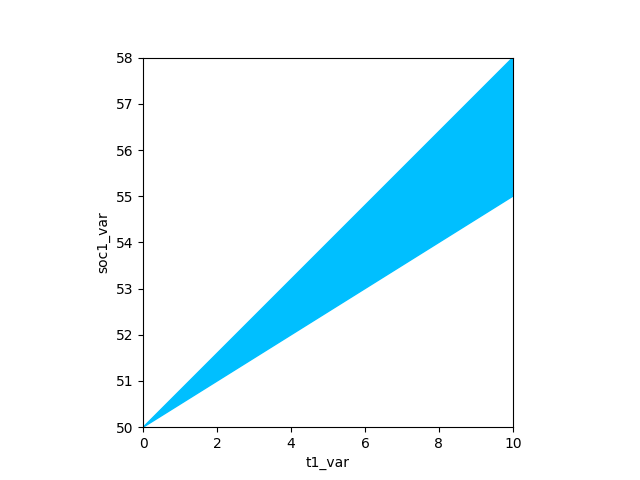

In [19]:
fig1 = plot_input_output_polyhedral_term_list(ce1, Var("t1_var"), Var("soc1_var"))

In [24]:
ce2: PolyhedralTermList = constraints \
.evaluate({
    Var("duration1"): 10.0,
    Var("duration2"): 10.0,
    Var("t1_entry"): 0,
    Var("soc1_entry"): 50.0,
    Var("soc1_var"):57.0,
    Var("output_soc1"):57.0,
    Var("t1_var"):10.0,
    Var("output_t1"):10.0,
}) \
.simplify() \
.elim_vars_by_relaxing(context=PolyhedralTermList([]),
    vars_to_elim=[
        Var("t2_exit"),
        Var("soc2_exit"), 
    ])
print(f"ce2:\n{ce2}")

ce2:
[
  soc2_var + 0.6 t2_var <= 63
  -soc2_var - 1.2 t2_var <= -69
  t2_var <= 20
]


In [25]:
t2_bounds=get_bounds(ce2, "t2_var")
print(f"t2_var bounds: {t2_bounds}")
soc2_bounds=get_bounds(ce2, "soc2_var")
print(f"soc2_var bounds: {soc2_bounds}")

t2_var bounds: (10.0, 20.0)
soc2_var bounds: (45.0, 57.0)


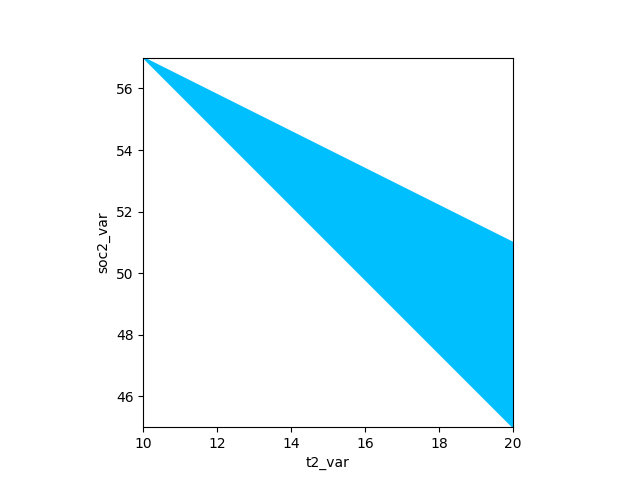

In [26]:
fig2 = plot_input_output_polyhedral_term_list(ce2, Var("t2_var"), Var("soc2_var"))